In [ ]:
 import zipfile
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/DS4440_Project/data/original/preprocessed_images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2176_right.jpg  
  inflating: preprocessed_images/2177_left.jpg  
  inflating: preprocessed_images/2177_right.jpg  
  inflating: preprocessed_images/2178_left.jpg  
  inflating: preprocessed_images/2178_right.jpg  
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/218_left.jpg  
  inflating: preprocessed_images/218_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflatin

In [ ]:
# Imports
import pandas as pd
import torch
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
# Create CustomDataset Class
class CustomDataset(Dataset):
  def __init__(self, root_dir, label_file, transform=None, label="ALL"):
        self.root_dir = root_dir
        self.label_file = label_file
        self.transform = transform
        self.label = label
        if self.label == "ALL":
          self.labels_df = pd.read_csv(label_file)
        else: # only load images of the given label
          label_df = pd.read_csv(label_file)
          label_df = label_df[label_df['labels']==self.label].reset_index(drop=True)
          self.labels_df = label_df
        self.image_files = os.listdir(root_dir)

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        # Extract label from the label file
        filename = self.image_files[idx]
        if self.label=='ALL':
          label = self.labels_df.loc[self.labels_df['filename'] == filename]['labels'].item()
        else:
          label = self.label
        # Convert label to label class, to get index for encoding
        label_ind = LABEL_TO_CLASS[label]
        # one hot encoding for labels:
        label_encoded = torch.zeros(NUM_CLASSES)
        label_encoded[label_ind] = 1

        return image, label_encoded

In [ ]:
# CONSTANTS

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # (GPU if available)

nz: int = 128  # length of latent vector
ngf: int = 128  # depth of feature maps carried through the generator.
ndf: int = 64  # depth of feature maps propagated through the discriminator
nc: int = 3  # number of color channels (for color images = 3)
# niter: int = NUM_EPOCHS BATCH_SIZE  # 300
n_dnn: int = 64  # number of output features of the label's linear

# Image and Label Constants
IMAGE_SIZE: int = 64  # 128
LABEL_TO_CLASS: dict = {
    'N': 0,
    'D': 1,
    'G': 2,
    'C': 3,
    'A': 4,
    'H': 5,
    'M': 6,
    'O': 7
}
LABEL_TO_TITLE: dict = {
    'N': "Normal",
    'D': "Diabetes",
    'G': "Galucoma",
    'C': "Cataract",
    'A': "Age related Macular Degeneration",
    'H': "Hypertension",
    'M': "Pathological Myopia",
    'O': "Other diseases/abnormalities"
}
CLASS_TO_LABEL: dict = {_v: _k for _k, _v in LABEL_TO_CLASS.items()}
NUM_CLASSES: int = len(LABEL_TO_CLASS)

# ---------------------
# Training parameters
# ---------------------
BATCH_SIZE: int = 64 if IMAGE_SIZE == 64 else 32
NUM_EPOCHS: int = 200

# ---------------------
# Hyperparameters
# ---------------------
# kept same hyperparameters as https://arxiv.org/pdf/1511.06434.pdf
LEARNING_RATE: float = 0.0002
BETA_1: float = 0.5

## Image Augmentation

In [ ]:
from torchvision.transforms import (
    Compose,
    Resize,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    RandomCrop,
    ColorJitter
)

from torchvision.utils import save_image
from tqdm import tqdm
from random import sample

In [ ]:
"""
Random Flip: Horizontal and Vertical
Random Rotation: Factor=0.75
Random Zoom: Factor = 0.05
Random Brightness Range=[0.01, 0.5]
"""
resize_size = 100
transform = Compose([
    RandomRotation(270),
    Resize((resize_size, resize_size)),
    RandomCrop(int(resize_size*0.95)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=(0.5,1.5), saturation=(0.5,1.5),hue=(-0.05,0.05)),
    transforms.ToTensor(),
    Normalize(mean=[0, ], std=[1, ])
    ])

In [ ]:
dataset = CustomDataset(root_dir='/content/preprocessed_images', label_file='/content/drive/MyDrive/DS4440_Project/data/original/odir_labels.csv', transform=transform, label='H')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

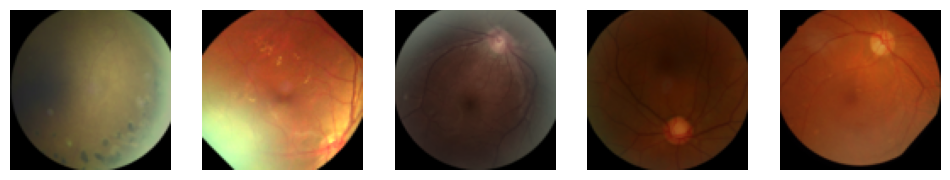

In [ ]:
# Tests that the Data is Properly Loaded by Printing
def show_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        if image.shape[0] == 1:
            axs[i].imshow(image.squeeze(), cmap='gray')
        else:
            axs[i].imshow(image.permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()

images, labels = next(iter(dataloader))
show_images(images)
#print("Labels:", labels)

In [ ]:
odir_df = pd.read_csv('/content/drive/MyDrive/DS4440_Project/data/original/odir_labels.csv')

In [ ]:
x = list(odir_df.labels.unique())
y_before = [odir_df['labels'].value_counts()[label] for label in x]

label_to_count = dict()
for lab in zip(x, y_before):
    label_to_count[lab[0]] = lab[1]

print(label_to_count)

{'N': 2873, 'D': 1608, 'O': 708, 'M': 232, 'H': 128, 'C': 293, 'A': 266, 'G': 284}


In [ ]:
# Generate Images
goal_samples = 1600
BATCH_SIZE = 50

img_id = 0
aug_filenames = []
aug_labels = []

aug_folder = "aug_balanced_imgs"
os.makedirs(aug_folder, exist_ok=True)

for label in tqdm(label_to_count.keys()):
  # calculate number of images needed to be generated
  cur_samples = label_to_count[label]

  to_generate = goal_samples - cur_samples
  num_batches = to_generate // BATCH_SIZE

  if to_generate < BATCH_SIZE: # if goal is met, no need to generate
    continue

  for _ in range(num_batches):
    # load images of the current label
    dataset = CustomDataset(root_dir='/content/preprocessed_images', label_file='/content/drive/MyDrive/DS4440_Project/odir_labels.csv', transform=transform, label=label)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    images, labels = next(iter(dataloader))
    # save / track the images and labels
    for img in images:
      filename = f"AUG_{img_id}.jpg"

      # save image to new directory
      save_image(img, f'{aug_folder}/{filename}')
      # keep track of new images
      aug_filenames.append(filename)
      aug_labels.append(label) # append letter label
      img_id += 1

100%|██████████| 8/8 [01:02<00:00,  7.83s/it]


In [ ]:
# choose sample of the largest class (N) to help with class balance
n_files = list(odir_df[odir_df['labels']=='N'].filename)
n_filenames = sample(n_files, goal_samples)

In [ ]:
other_filenames = list(odir_df[odir_df['labels']!='N'].filename)
og_imgs = n_filenames + other_filenames
print(len(og_imgs))

5119


In [ ]:
# copy original images into new class-balanced folder
#og_imgs = os.listdir('/content/preprocessed_images')

for img in tqdm(og_imgs):
  from_path = f'/content/preprocessed_images/{img}'
  to_path = f'/content/aug_balanced_imgs/{img}'
  !cp $from_path $to_path

100%|██████████| 5119/5119 [08:57<00:00,  9.53it/s]


In [ ]:
# check that the original image were moved
aug_imgs = os.listdir('/content/aug_balanced_imgs')

for img in og_imgs:
  if img not in aug_imgs:
    print(f"{img} not copied")

In [ ]:
!zip -r /content/aug_balanced_imgs.zip /content/aug_balanced_imgs

In [ ]:
# Get new filtered df, filenames that were copied over
odir_df = odir_df[odir_df['filename'].isin(og_imgs)]

# Add augmented labels to old df
# create df for augmented filename and labels
aug_dict = {'filename': aug_filenames, 'labels': aug_labels}
aug_df = pd.DataFrame(aug_dict)

# merge the two dataframes containing aug and original data
balanced_df = pd.concat([odir_df, aug_df])

# Check distribution:
x = list(balanced_df.labels.unique())
y_before = [balanced_df['labels'].value_counts()[label] for label in x]

label_to_count = dict()
for lab in zip(x, y_before):
    label_to_count[lab[0]] = lab[1]

print(label_to_count)


{'N': 1600, 'D': 1608, 'O': 1558, 'M': 1582, 'H': 1578, 'C': 1593, 'A': 1566, 'G': 1584}


In [ ]:
# Export new CSV
balanced_df.to_csv('/content/balanced_odir_labels.csv', index=False)

In [ ]:
# Download New Data
from google.colab import files
files.download("/content/aug_balanced_imgs.zip")
files.download("/content/balanced_odir_labels.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Choosing Smaller Dataset

In [ ]:
odir_df = pd.read_csv('/content/drive/MyDrive/DS4440_Project/data/original/odir_labels.csv')

In [ ]:
# Generate Images
goal_samples = 50
BATCH_SIZE = 10

sub_filenames = []
sub_labels = []

sub_folder = "preprocessed_imgs_sub50"
os.makedirs(sub_folder, exist_ok=True)

for label in tqdm(label_to_count.keys()):
  # calculate number of images needed to be generated
  cur_files = list(odir_df[odir_df['labels']==label].filename)
  cur_filenames = sample(cur_files, goal_samples)


  sub_filenames += cur_filenames
  for _ in range(len(cur_filenames)):
    sub_labels.append(label)

100%|██████████| 8/8 [00:00<00:00, 757.92it/s]


In [ ]:
# copy original images into new class-balanced folder
#og_imgs = os.listdir('/content/preprocessed_images')

for img in tqdm(sub_filenames):
  from_path = f'/content/preprocessed_images/{img}'
  to_path = f'/content/{sub_folder}/{img}'
  !cp $from_path $to_path

100%|██████████| 400/400 [00:42<00:00,  9.43it/s]


In [ ]:
!zip -r /content/preprocessed_imgs_sub50.zip /content/preprocessed_imgs_sub50

In [ ]:
# Get new filtered df, filenames that were copied over
odir_df = odir_df[odir_df['filename'].isin(sub_filenames)]

# Add augmented labels to old df
# create df for augmented filename and labels
sub_dict = {'filename': sub_filenames, 'labels': sub_labels}
sub_df = pd.DataFrame(sub_dict)

# Check distribution:
x = list(sub_df.labels.unique())
y_before = [sub_df['labels'].value_counts()[label] for label in x]

label_to_count = dict()
for lab in zip(x, y_before):
    label_to_count[lab[0]] = lab[1]

print(label_to_count)


{'N': 50, 'D': 50, 'O': 50, 'M': 50, 'H': 50, 'C': 50, 'A': 50, 'G': 50}


In [ ]:
# Export new CSV
sub_df.to_csv('/content/balanced_odir_labels.csv', index=False)

In [ ]:
# Download New Data
from google.colab import files
files.download("/content/preprocessed_imgs_sub50.zip")
files.download("/content/sub_odir_labels.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>